In [1]:
from OAH_refocus import *
import matplotlib.pyplot as plt 
from OAHDEV_functions import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.signal import savgol_filter

import os
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
from IPython.display import display, HTML

import tkinter as tk
from tkinter import filedialog
from PIL import Image as PILImage

display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib notebook

def bin_image(arr, factor=4):
    h, w = arr.shape
    h_trim = (h // factor) * factor
    w_trim = (w // factor) * factor
    trimmed_arr = arr[:h_trim, :w_trim] 
    # Reshape and bin by averaging blocks
    binned_arr = trimmed_arr.reshape(h_trim // factor, factor, w_trim // factor, factor).mean(axis=(1, 3))
    return binned_arr

# Function to select multiple PNG files
def select_files(initial_dir="/home/bec_lab/Desktop/imgs/"):
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    root.attributes('-topmost', True)  # Ensure it stays on top
    file_selected = filedialog.askopenfilenames(
        title='Select PNG Files',
        initialdir=initial_dir,
        filetypes=[("PNG Files", "*.png")])
    root.destroy()  # Close the Tkinter window
    return file_selected if file_selected else None

# Function to create a GIF from selected images
def create_gif(image_files, output_gif="output.gif", frame_duration=100):
    if not image_files:
        print("No files selected.")
        return None

    images = [PILImage.open(file) for file in sorted(image_files)]

    output_dir = os.path.dirname(image_files[0])  # Save GIF in the same directory as the images
    output_path = os.path.join(output_dir, output_gif)

    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        duration=frame_duration,
        loop=0
    )
    print(f"GIF saved as {output_path}")
    
    return output_path  # Return the path of the created GIF

def on_create_clicked(b):
    with output:
        output.clear_output()
        files = select_files()
        if files:
#             print(f"Selected Files: {files}")
            gif_path = create_gif(files)
            if gif_path:
                display(Image(filename=gif_path))  # Display the GIF
                button_close.disabled = False  # Enable close button
        else:
            print("No files selected.")

def on_close_clicked(b):
    with output:
        output.clear_output()
        print("GIF closed.")
        button_close.disabled = True  # Disable close button again


# BACKGROUND

In [3]:
def HI_refocus_(date, shot, num, dz_focus, quad="quad1", output="ang", diff_flat=True, plot=False):
    """
    Main function for generating the output arrays for the holgoraphic imaging, which also includes the refocusing.
    What we do, is we process image - first take a FTT, apply Tukey windows, shift, refocus, and back iFFT.
    ------
    :param date: Input date of the image to be analysed
    :param shot: Input shot of the image to be analysed
    :param num: Input sequence number of the image to be analysed
    :param dz_focus: The focus parameter that determines the focus of the image
    :param quad: Parameter to determine which quad we are cutting.
    :param output: Output the phase (ang) or amplituide (amp)
    :param plot: Boolean to specify whether to plot the image of the angle or not. Better not when used in a loop.
    :return: Returns an array of the angle of the ratio of the iFFT's of the atom and flat image.
    """
    # ------------------------------------------------- IMPORTS -----------------------------------------------------
    path = '/storage/data/' + str(date) + '/'
    image = str(shot).zfill(4) + '/'
    
    # Opening files
    atoms = pyfits.open(path + image + '0.fits')[0].data.astype(float)[num]
    if diff_flat:
        flat = pyfits.open(path + image + '1.fits')[0].data.astype(float)[num]
    else: 
        flat = pyfits.open(path + image + '1.fits')[0].data.astype(float)[0]
        
    dark = pyfits.open(path + image + '2.fits')[0].data.astype(float).mean(axis=0)
    # ----------------------------------------------- CORRECTIONS ---------------------------------------------------
    # Creates a squaroid dark edge
    atoms = f1.squaroid(atoms - dark, width=0.51)
    flat = f1.squaroid(flat - dark, width=0.51)

    # --------------------------------------------------- FFT --------------------------------------------------------
    # Take the FTT of the atoms
    fft_atoms = np.fft.fft2(atoms)
    fft_flat = np.fft.fft2(flat)

    # We create the Tukey windows cutouts for the data and the background. Additional cuts in x,z direction can be
    # passed, but this is optional; the default value is 0. Note that because you later cut everything in the
    # same size, this may affect the rest too.
    quad1, q1peak = f1.box_cutter_pad_ellips(fft_atoms, quad, 10, 100, edge_x=10, edge_z=80)
    flatq1, f1peak = f1.box_cutter_pad_ellips(fft_flat, quad, 10, 100, edge_x=10, edge_z=80) #indices=q1peak)

    # Cutting the quads in the same sizes.
    quad1cut, flatq1cut = f1.sizecomp(quad1, flatq1)

    # ------------------------------------------------ FFT SHIFT ----------------------------------------------------
    # Now we FFT shift the zero frequency to the center
    fft1 = np.fft.fftshift(quad1cut)
    flatfft1 = np.fft.fftshift(flatq1cut)

    # ------------------------------------------------ REFOCUSING ---------------------------------------------------
    fft_kx = np.fft.fftfreq(fft1.shape[1], d=pix_size)  # Discrete FFT Sample Frequency in x
    fft_ky = np.fft.fftfreq(fft1.shape[0], d=pix_size)  # Discrete FFT Sample Frequency in z
    fft_k2 = fft_kx[None, :] ** 2 + fft_ky[:, None] ** 2  # Discrete FFT Sample Frequency in main axes multiplied
    ly = 0  # .5E6#-3E6#.                                           # Adjusting the fft_ky array
    coma_y_arg = ly * fft_ky[:, None] * (3 * fft_k2 / k0 ** 2) / k0
    lin_y = np.exp(-1j * coma_y_arg)

    # Determine the focus factor and refocus
    focus = np.exp(-1j * fft_k2 * dz_focus / (2 * k0))
    fft1 = fft1 * focus * lin_y
    flatfft1 = flatfft1 * focus * lin_y

    # ------------------------------------- INVERSE FFT -------------------------------------------------
    inv1 = np.fft.ifft2(fft1) / np.fft.ifft2(flatfft1)
    inv1 = inv1[border_x:-border_x, border_z:-border_z]

    # Get Phase
    ang1 = np.angle(inv1)
    ang1 = f1.unwrapper(ang1)
    amp1 = np.abs(inv1) ** 2

    # Normalize
    normfactor = ang1.mean()  # [300:900, 300:900].mean()
    ang1 = ang1 - normfactor 
    ang1 = normalize(ang1)[0] # Use the function above to normalize the image.

    if plot:
        plt.imshow(ang1, cmap='Greys', interpolation='none', origin="lower")
        plt.title(str(dz_focus))
        plt.colorbar()
        plt.show()

    if output == "amp":
        return amp1
    else: 
        return ang1

In [4]:
ang1s = [HI_refocus_(20250214, 197, num, 0.0033, "quad1", output="amp", diff_flat=True) for num in range(25)]
ang2s = [HI_refocus_(20250214, 197, num, 0.0033, "quad2", output="amp", diff_flat=True) for num in range(25)]

Using the new box cutter
------ r='quad1' ------
(array([88]), array([628]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([627]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([89]), array([627]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([627]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([88]), array([625]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([626]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([88]), array([625]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([626]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([88]), array([626]))
Using the new box cutter
------ r='quad1' ------
(array([89]), array([628]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([89]), array([627]))
Using the new box cutter
------ r

Using the new box cutter
------ r='quad2' ------
(array([84]), array([1936]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1932]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1930]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1931]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1930]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1932]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1929]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1934]))
(300, 2560) (300, 2560)


In [6]:
ang1s_sameflat = [HI_refocus_(20250214, 197, num, 0.0033, "quad1", output="amp", diff_flat=False) for num in range(25)]
ang2s_sameflat = [HI_refocus_(20250214, 197, num, 0.0033, "quad2", output="amp", diff_flat=False) for num in range(25)]

Using the new box cutter
------ r='quad1' ------
(array([88]), array([628]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([627]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([89]), array([627]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([627]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([88]), array([625]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([627]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([88]), array([625]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([627]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([88]), array([626]))
Using the new box cutter
------ r='quad1' ------
(array([88]), array([627]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad1' ------
(array([89]), array([627]))
Using the new box cutter
------ r

Using the new box cutter
------ r='quad2' ------
(array([84]), array([1936]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1935]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1930]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1935]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1930]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1935]))
(300, 2560) (300, 2560)
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1929]))
Using the new box cutter
------ r='quad2' ------
(array([84]), array([1935]))
(300, 2560) (300, 2560)


<IPython.core.display.Javascript object>


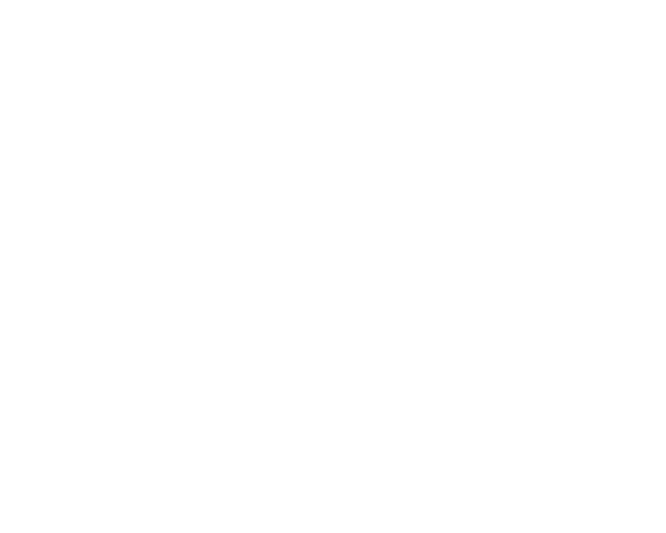

<IPython.core.display.Javascript object>


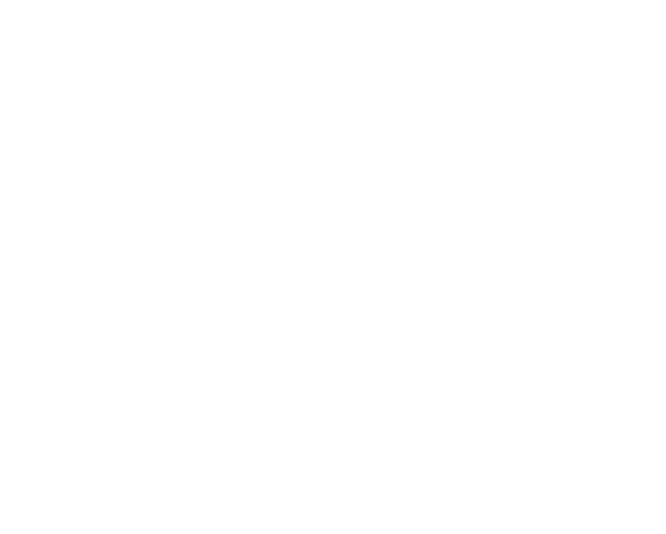

<IPython.core.display.Javascript object>


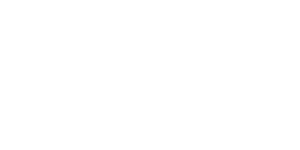

<IPython.core.display.Javascript object>


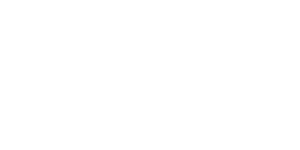

<IPython.core.display.Javascript object>


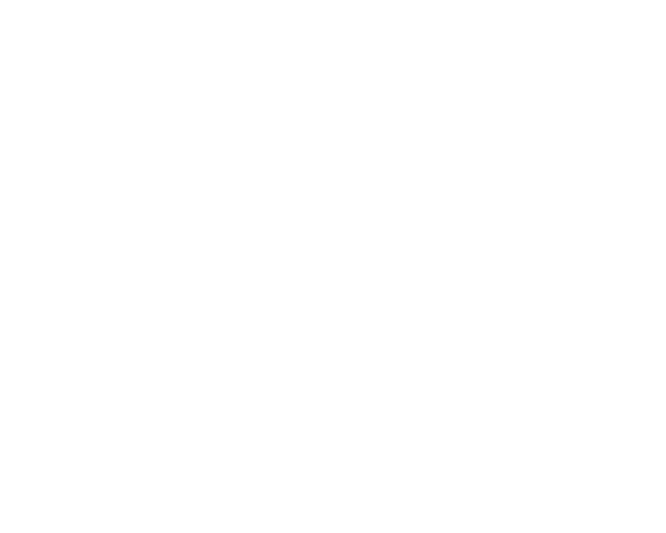

<IPython.core.display.Javascript object>


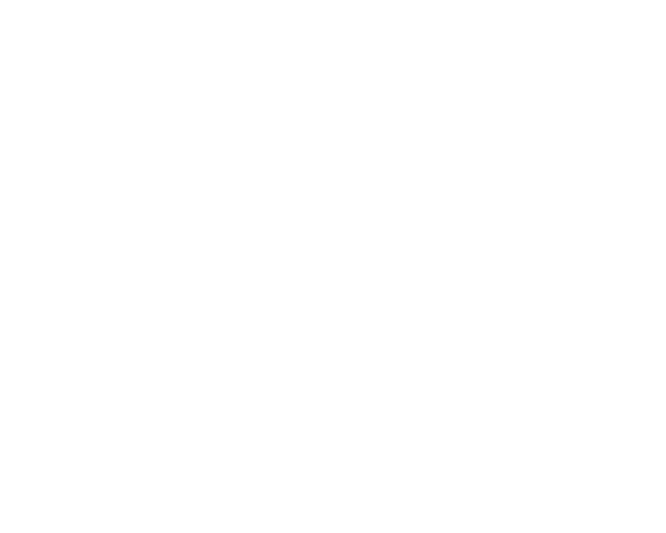

<IPython.core.display.Javascript object>


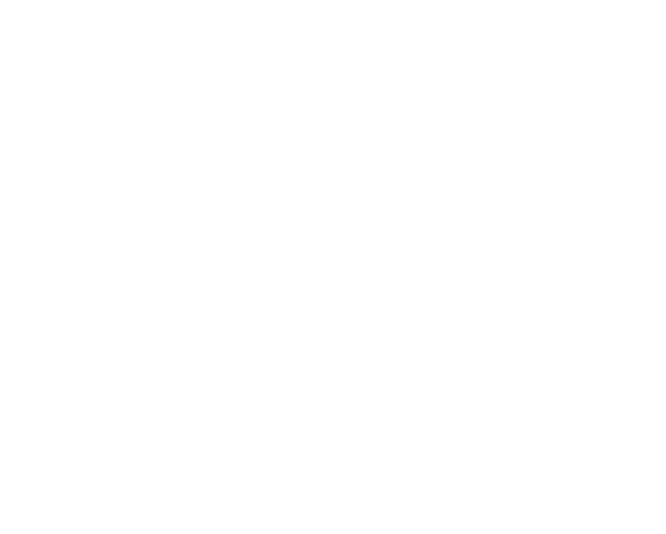

<IPython.core.display.Javascript object>


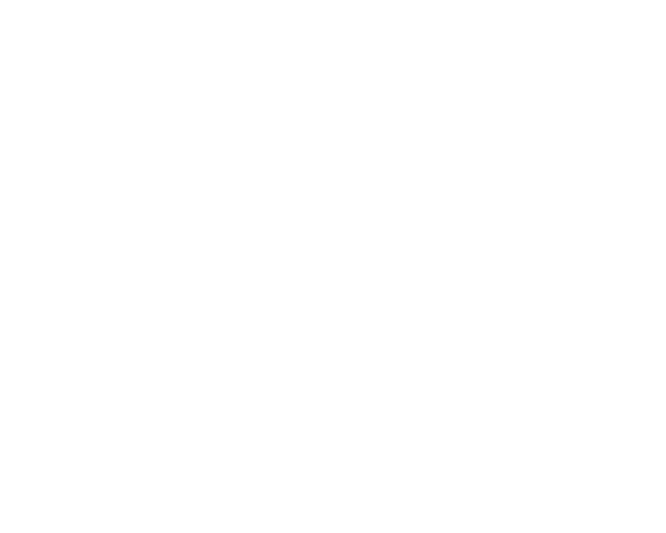

<IPython.core.display.Javascript object>


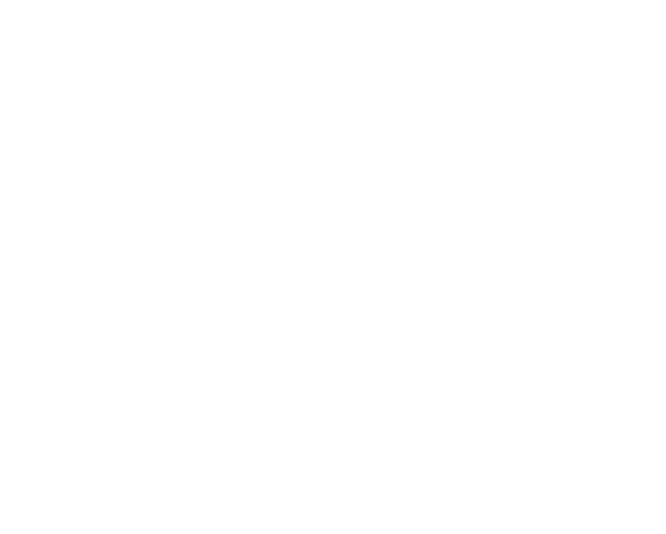

<IPython.core.display.Javascript object>


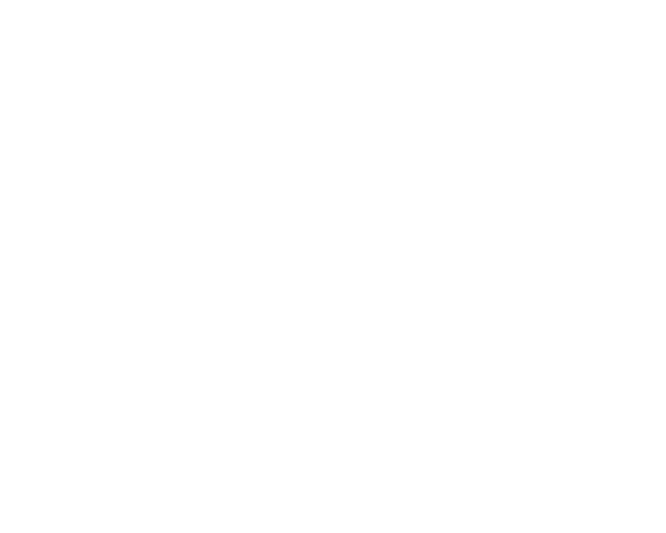

<IPython.core.display.Javascript object>


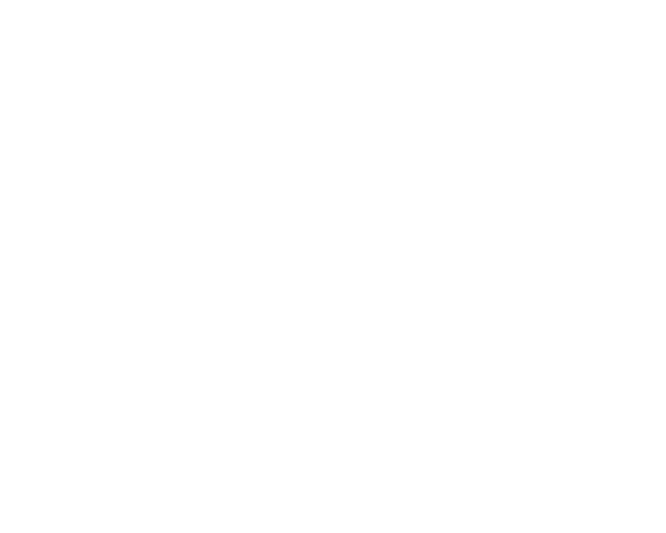

<IPython.core.display.Javascript object>


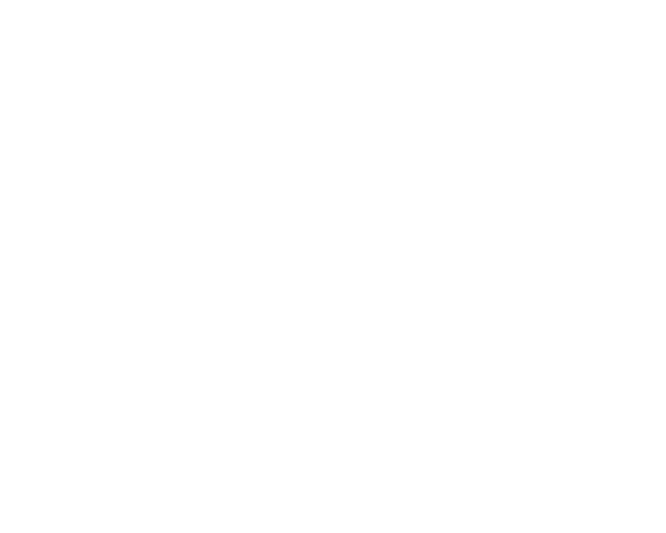

<IPython.core.display.Javascript object>


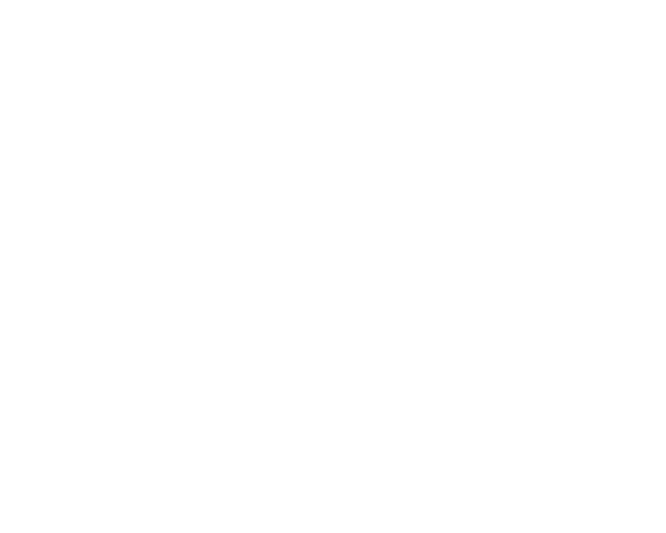

<IPython.core.display.Javascript object>


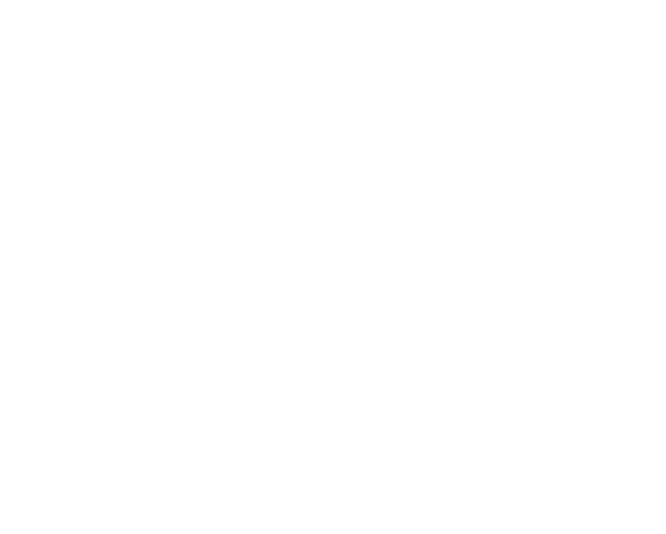

<IPython.core.display.Javascript object>


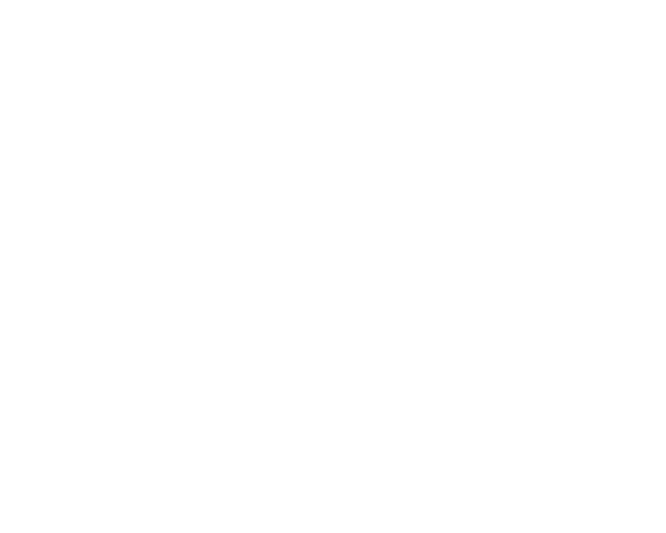

<IPython.core.display.Javascript object>


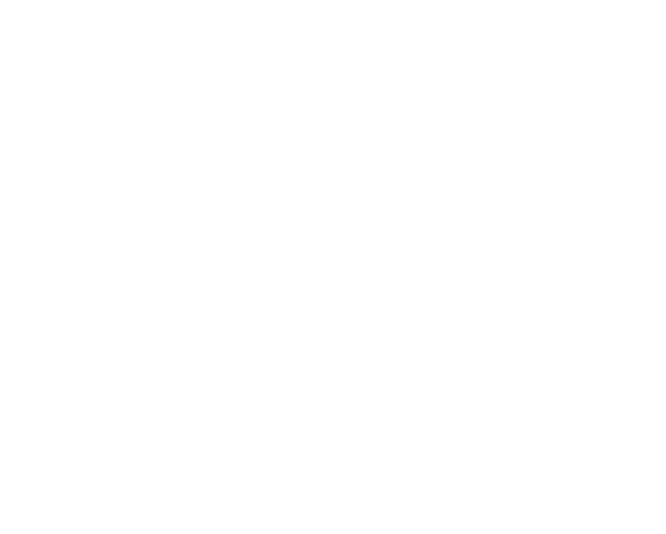

<IPython.core.display.Javascript object>


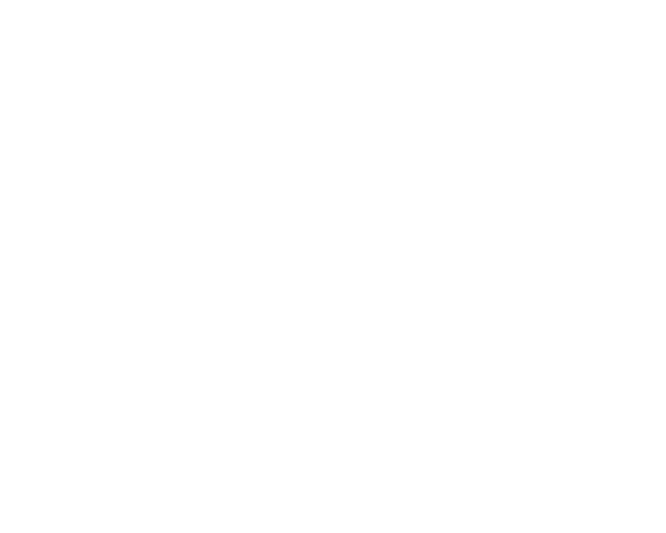

<IPython.core.display.Javascript object>


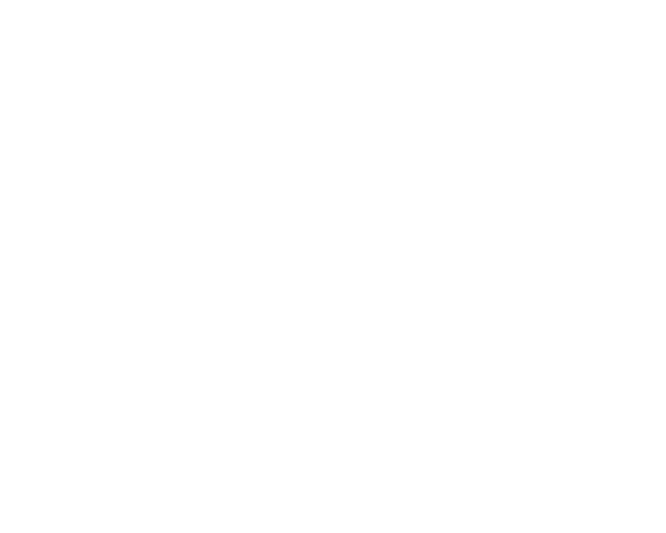

<IPython.core.display.Javascript object>


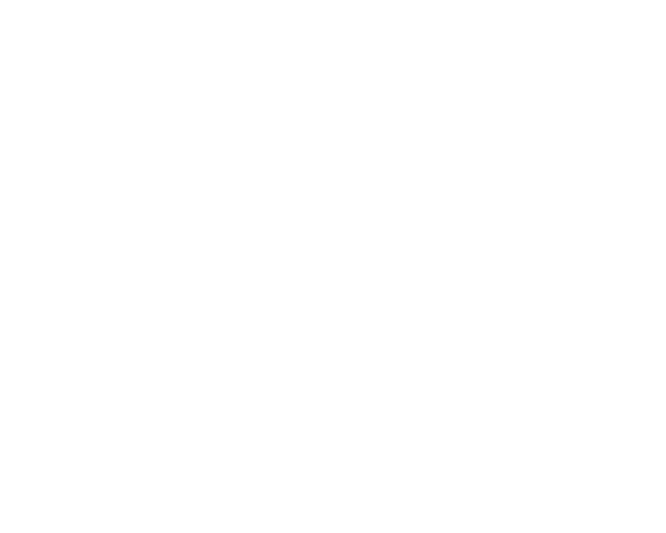

<IPython.core.display.Javascript object>


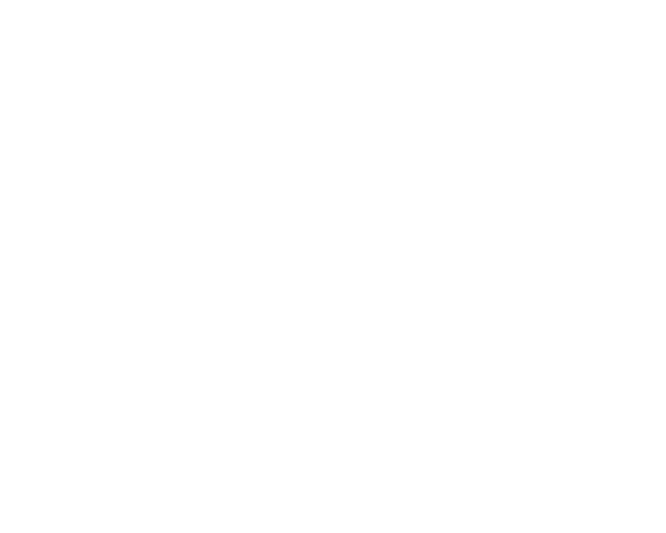

<IPython.core.display.Javascript object>


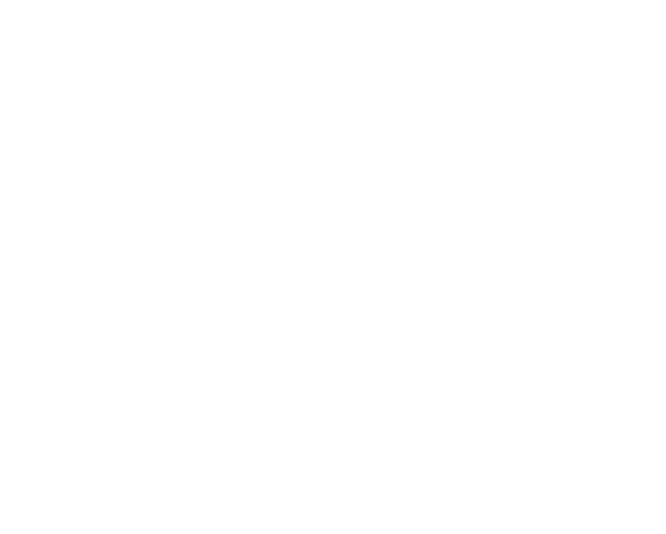

<IPython.core.display.Javascript object>


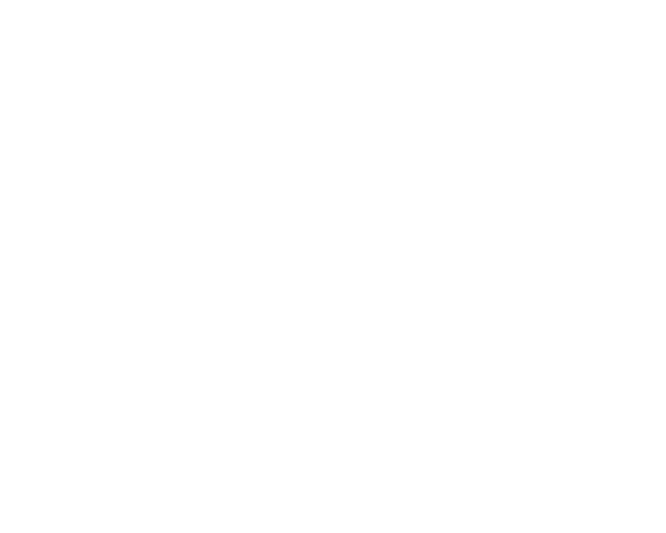

<IPython.core.display.Javascript object>


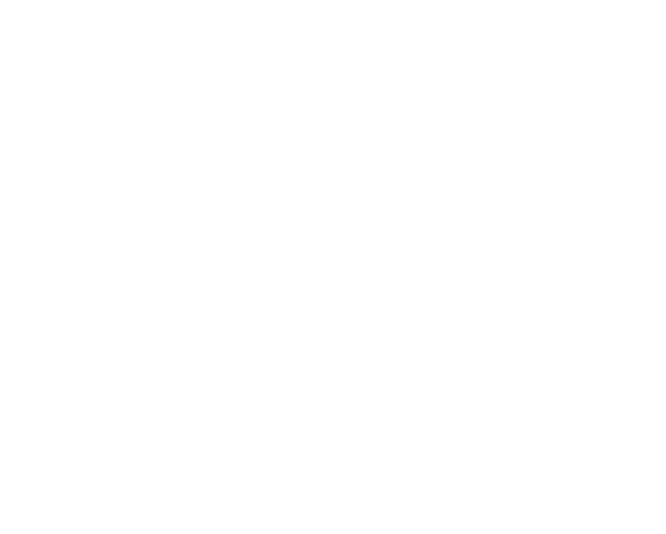

<IPython.core.display.Javascript object>


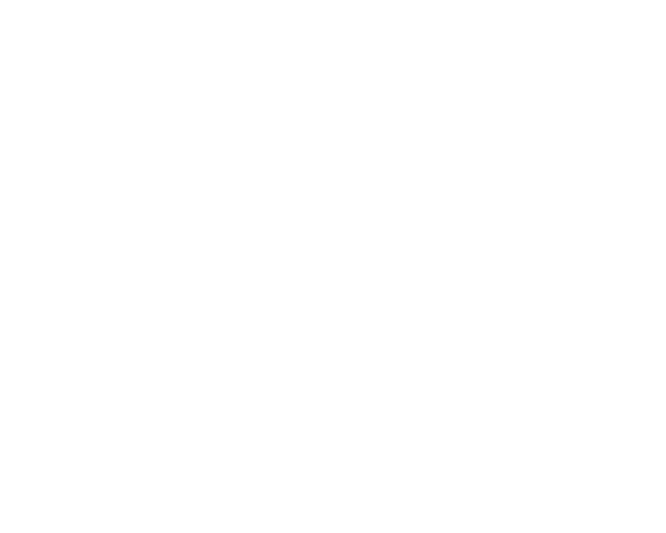

<IPython.core.display.Javascript object>


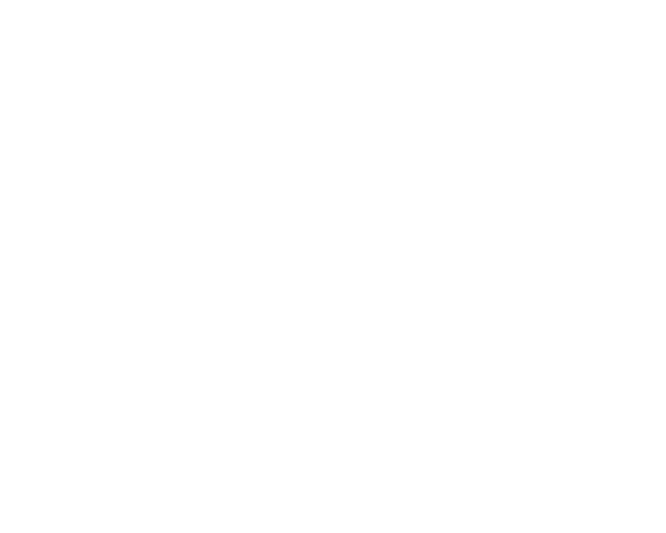

In [25]:
num = 0 
for num in range(25):
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    ax[0][0].imshow(ang1s[num][25:50, 600:700], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')
    ax[0][1].imshow(ang2s[num][25:50, 600:700], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')
    ax[1][0].plot(ang1s[num][50, 500:700], alpha=0.6, label="OAH1")
    ax[1][0].plot(ang2s[num][50, 500:700], alpha=0.6, label="OAH2")

    ax[1][1].plot(ang1s[num].T[50][50:250], alpha=0.6, label="OAH1")
    ax[1][1].plot(ang2s[num].T[50][50:250], alpha=0.6, label="OAH2")
    ax[1][1].set_ylim([-2, 6])
    ax[1][0].set_ylim([-2, 6])

    ax[1][0].legend()
    ax[1][1].legend()

    plt.suptitle(f"2025-02-14 -- 197 -- {num}")
    for a in fig.axes:
        a.set_yticks([])
        a.set_xticks([])

    ax
    plt.tight_layout()

    plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/DifferentFlat/True/{str(num).zfill(5)}.png")

    plt.close()

<IPython.core.display.Javascript object>


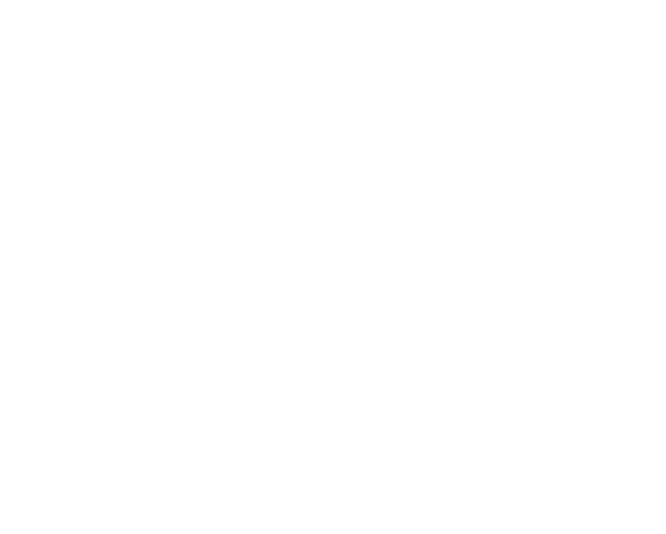

<IPython.core.display.Javascript object>


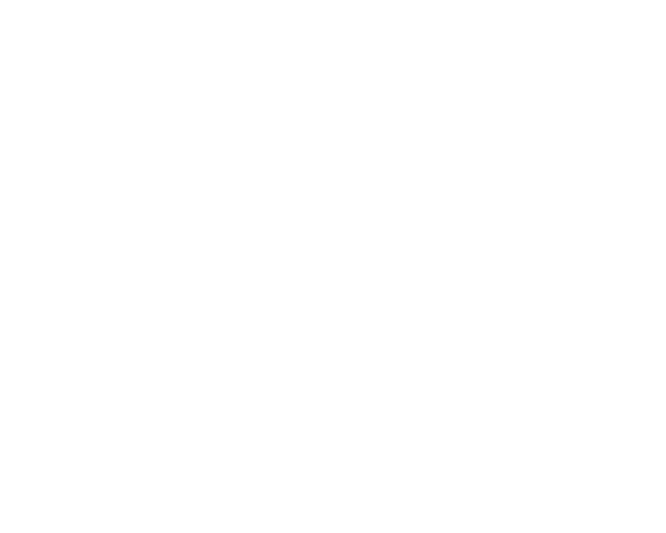

<IPython.core.display.Javascript object>


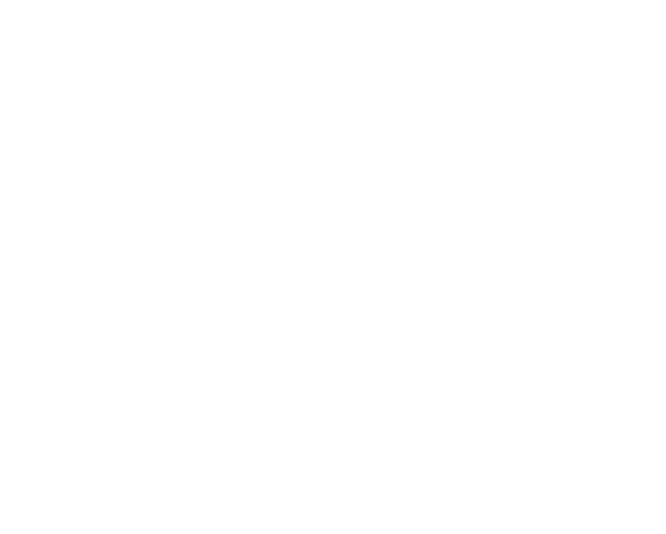

<IPython.core.display.Javascript object>


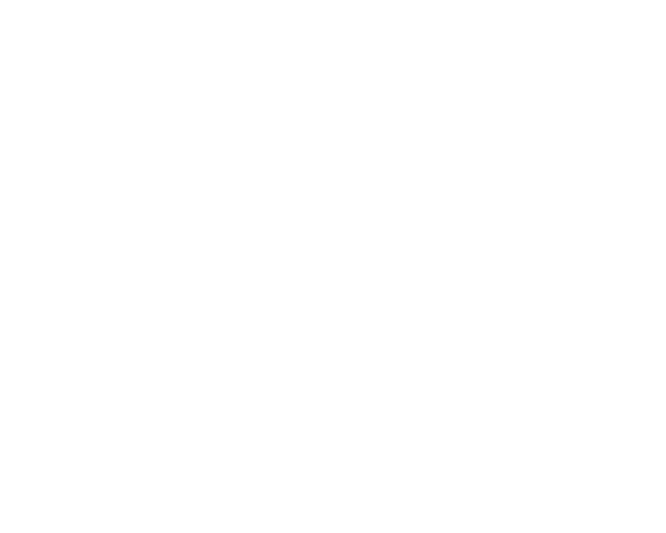

<IPython.core.display.Javascript object>


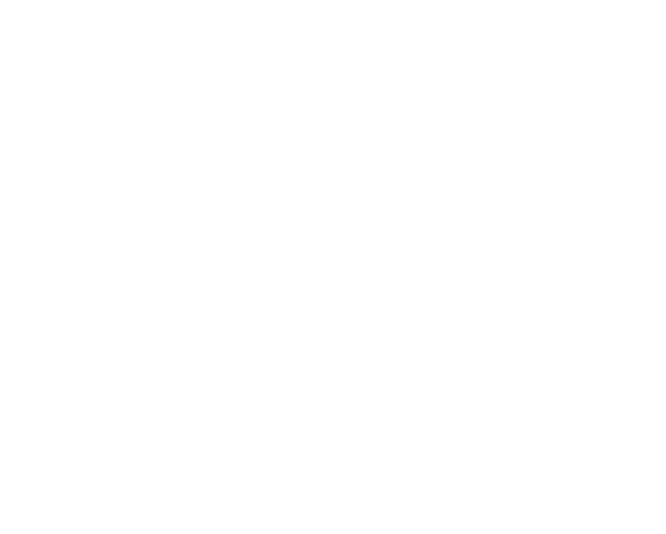

<IPython.core.display.Javascript object>


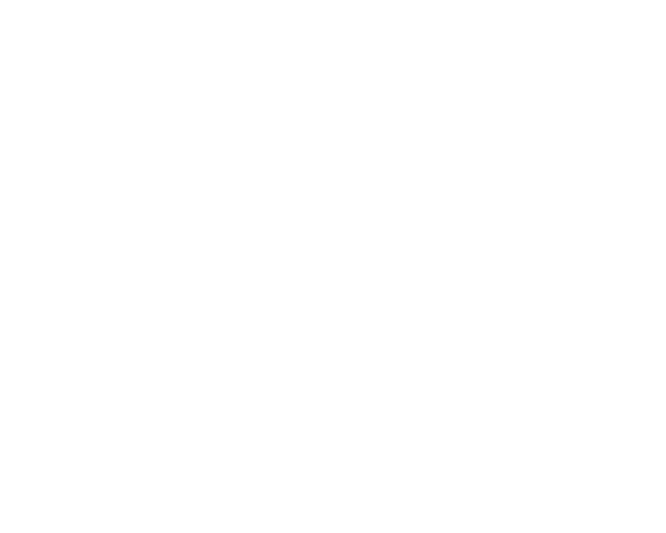

<IPython.core.display.Javascript object>


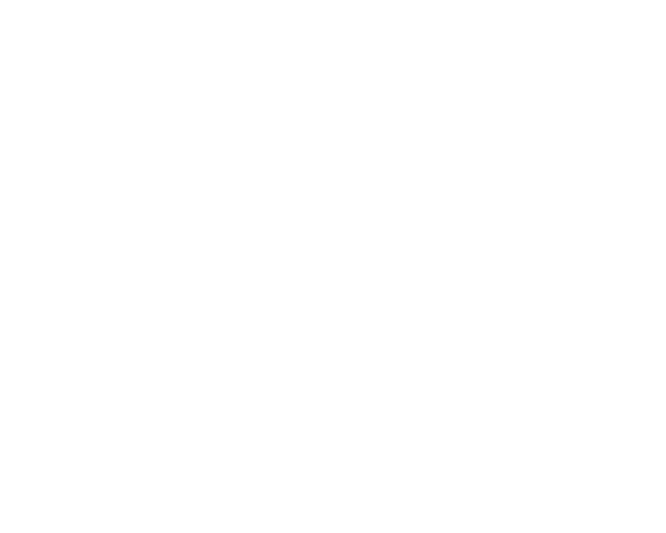

<IPython.core.display.Javascript object>


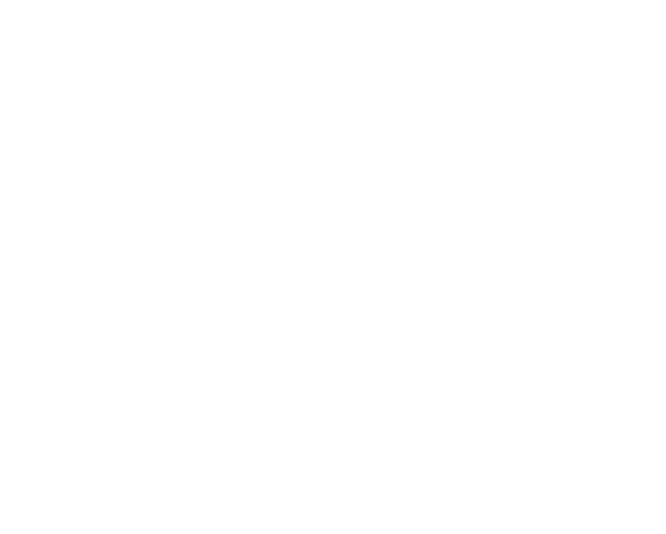

<IPython.core.display.Javascript object>


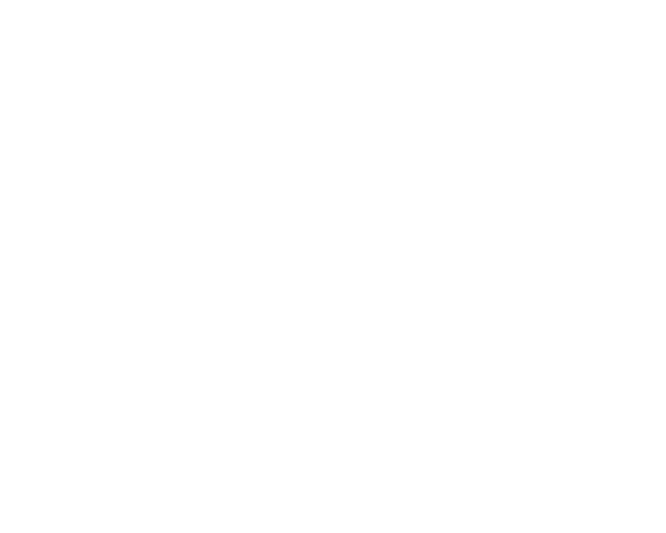

<IPython.core.display.Javascript object>


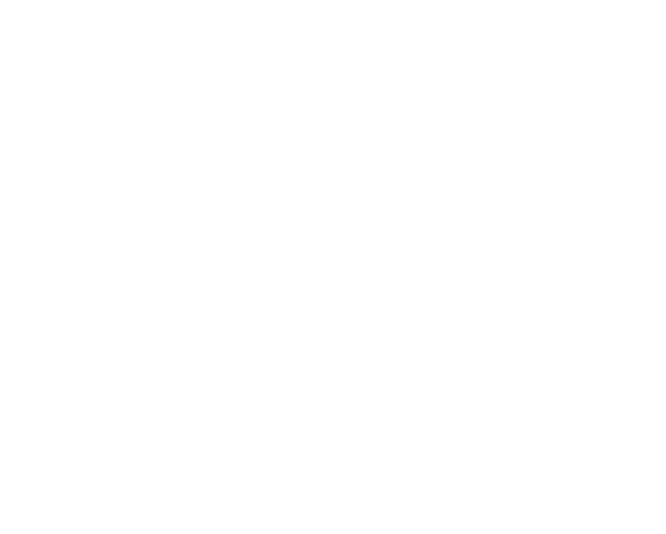

<IPython.core.display.Javascript object>


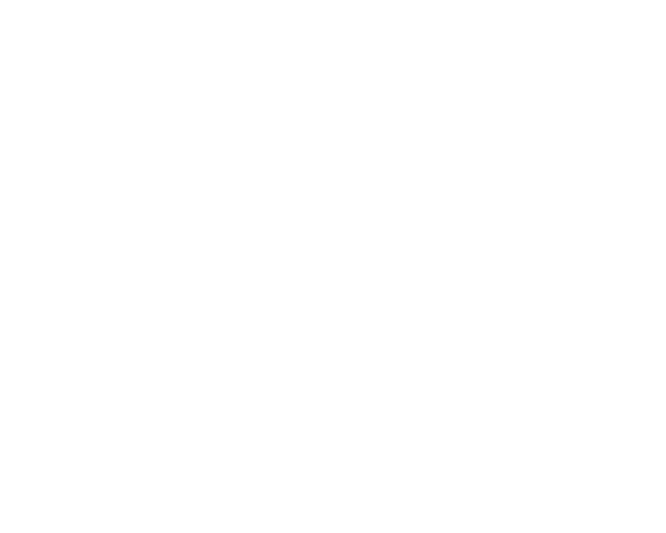

<IPython.core.display.Javascript object>


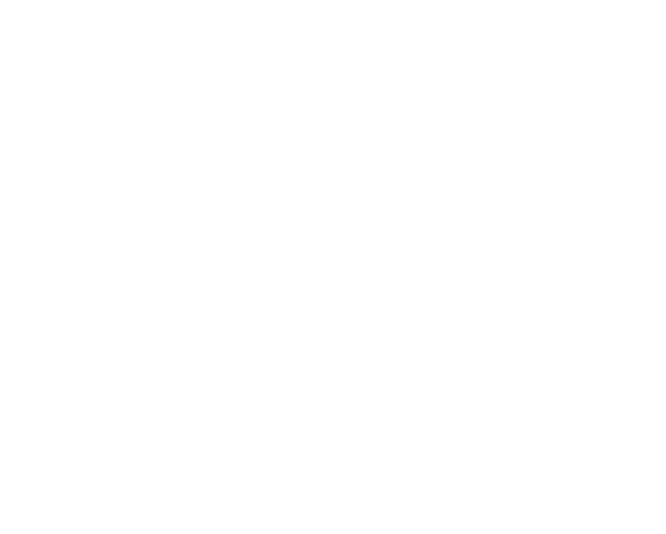

<IPython.core.display.Javascript object>


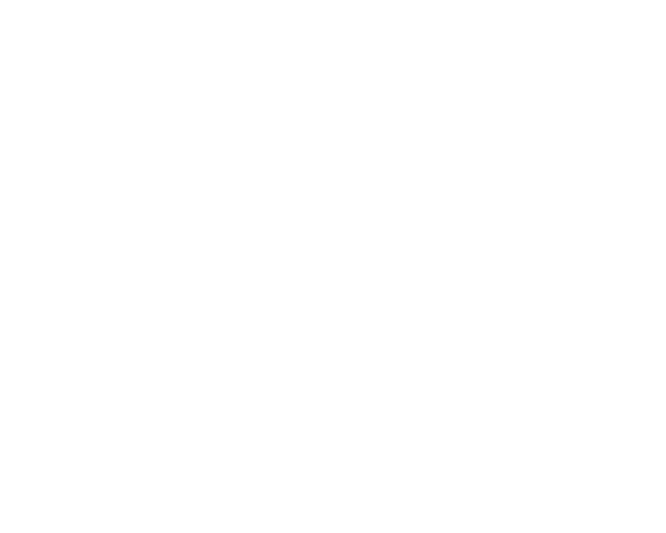

<IPython.core.display.Javascript object>


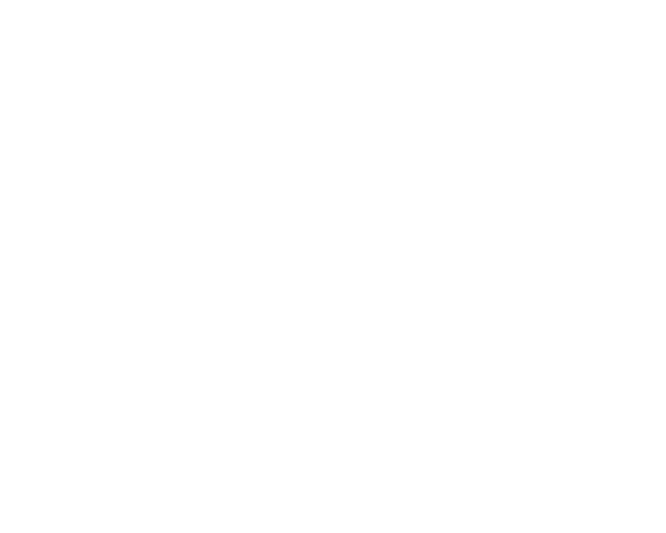

<IPython.core.display.Javascript object>


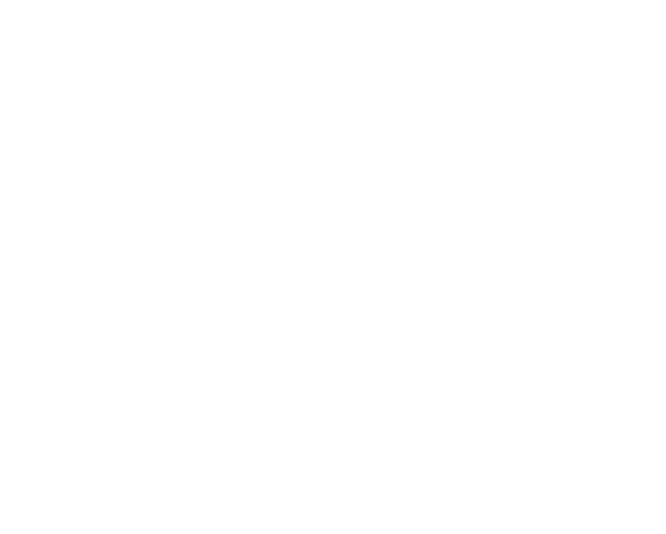

<IPython.core.display.Javascript object>


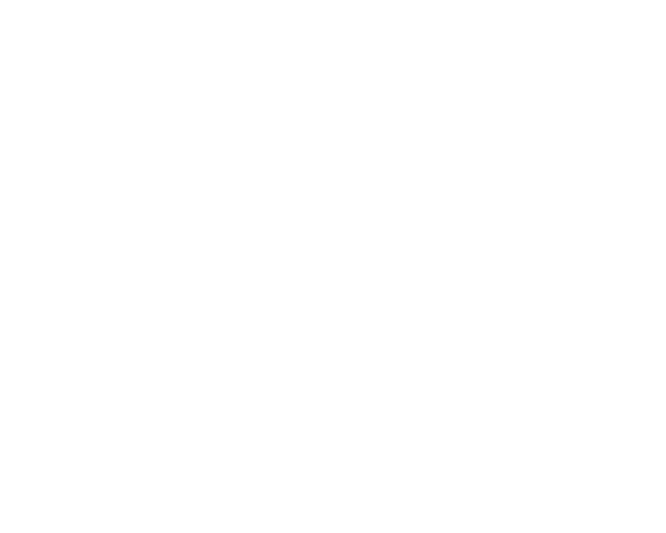

<IPython.core.display.Javascript object>


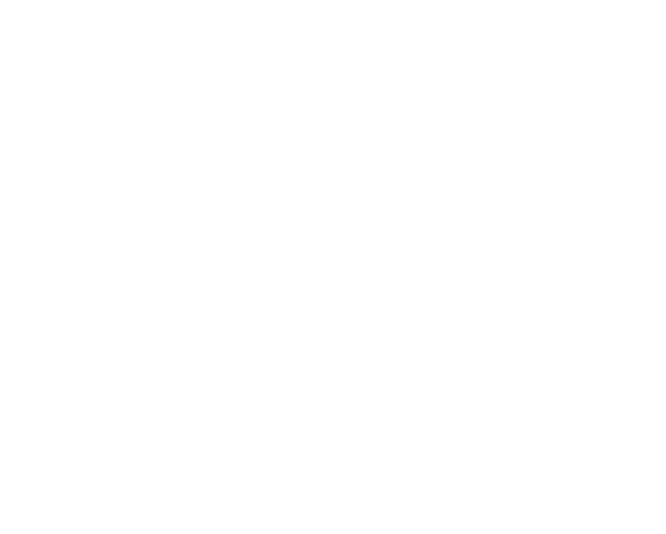

<IPython.core.display.Javascript object>


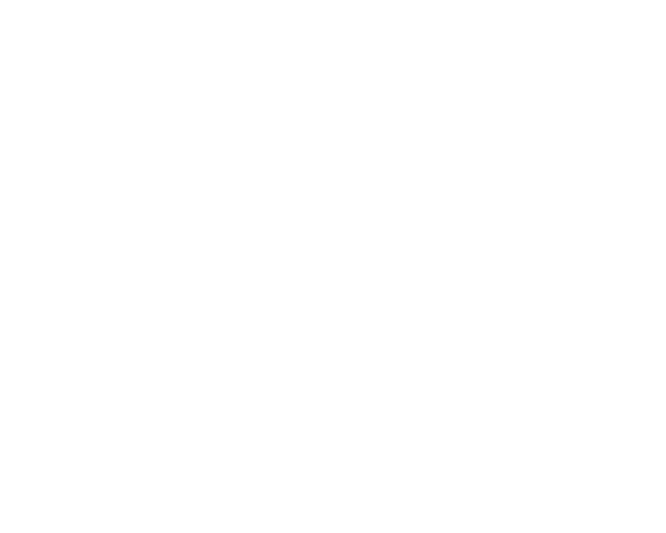

<IPython.core.display.Javascript object>


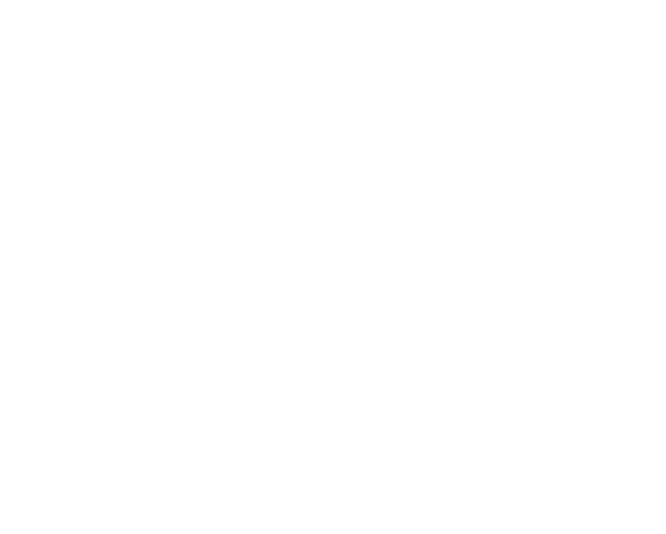

<IPython.core.display.Javascript object>


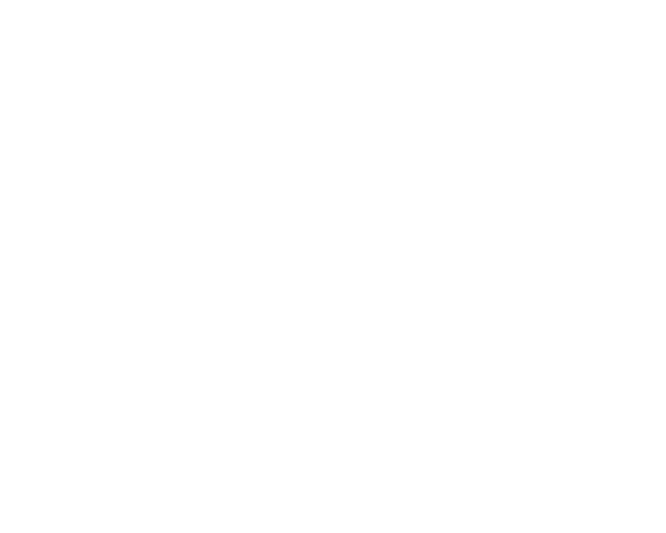

<IPython.core.display.Javascript object>


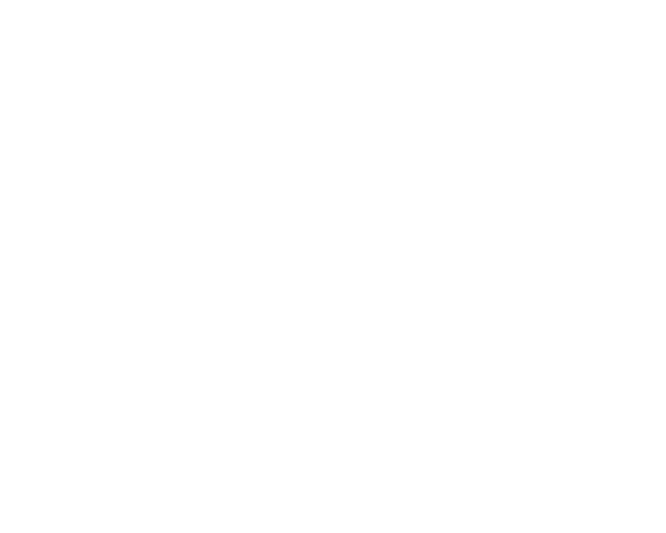

<IPython.core.display.Javascript object>


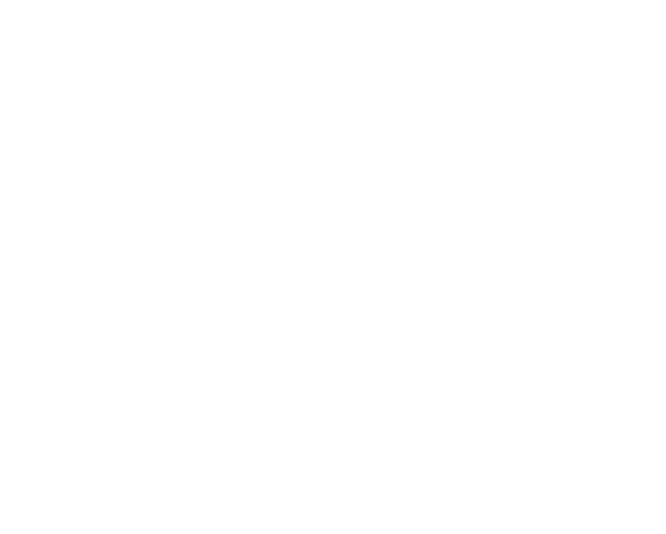

<IPython.core.display.Javascript object>


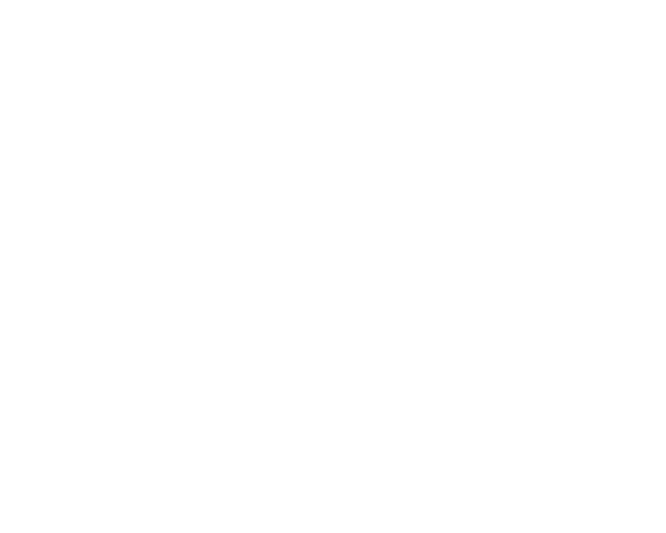

<IPython.core.display.Javascript object>


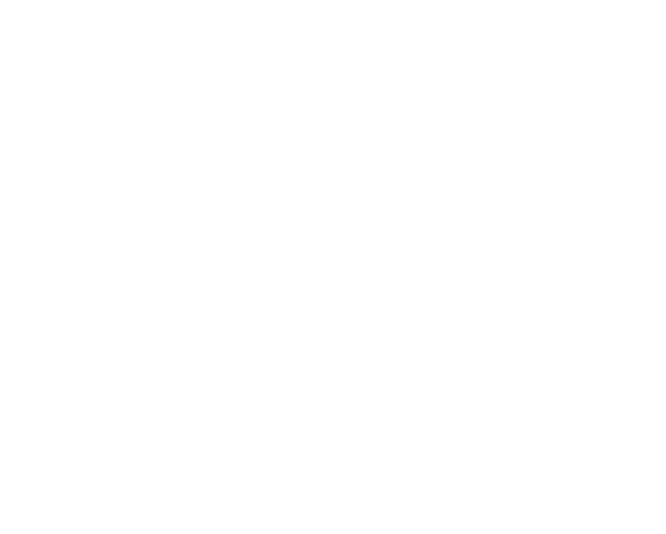

<IPython.core.display.Javascript object>

In [ ]:
num = 0 
for num in range(25):
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    ax[0][0].imshow(ang1s[num][25:50, 600:700], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')
    ax[0][1].imshow(ang2s[num][25:50, 600:700], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')
    ax[1][0].plot(ang1s[num][50, 500:700], alpha=0.6, label="OAH1")
    ax[1][0].plot(ang2s[num][50, 500:700], alpha=0.6, label="OAH2")

    ax[1][1].plot(ang1s[num].T[50][50:250], alpha=0.6, label="OAH1")
    ax[1][1].plot(ang2s[num].T[50][50:250], alpha=0.6, label="OAH2")
    ax[1][1].set_ylim([-2, 2])

    ax[1][0].legend()
    ax[1][1].legend()

    plt.suptitle(f"2025-02-14 -- 197 -- {num}")
    for a in fig.axes:
        a.set_yticks([])
        a.set_xticks([])

    ax
    plt.tight_layout()

    plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/DifferentFlat/True/{str(num).zfill(5)}.png")

    plt.close()

<IPython.core.display.Javascript object>


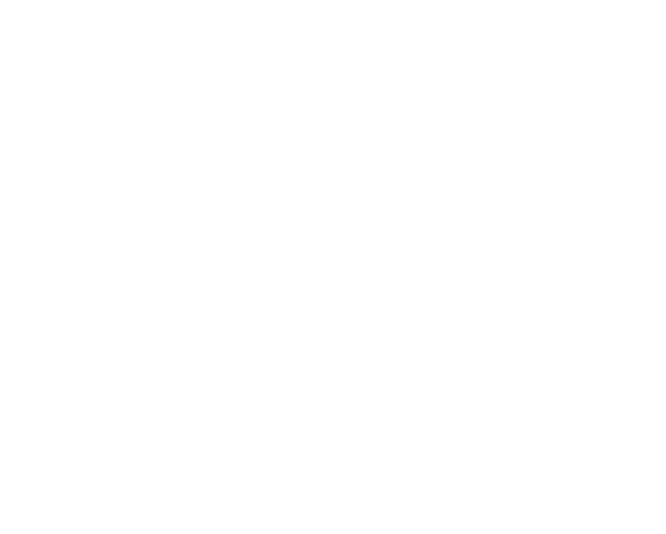

<IPython.core.display.Javascript object>


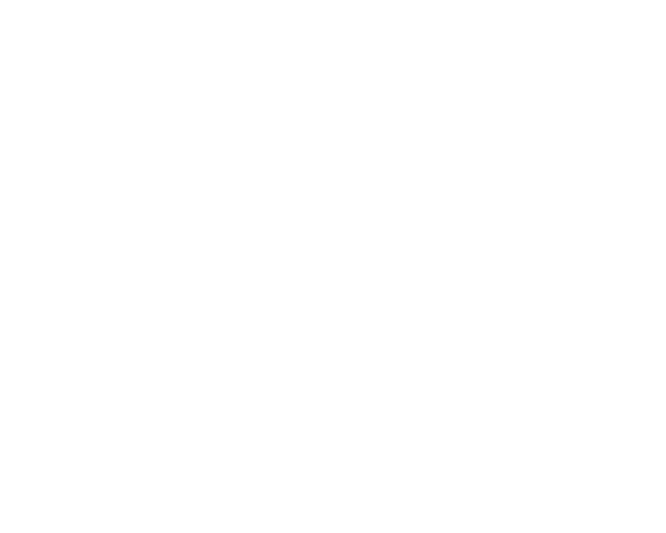

<IPython.core.display.Javascript object>


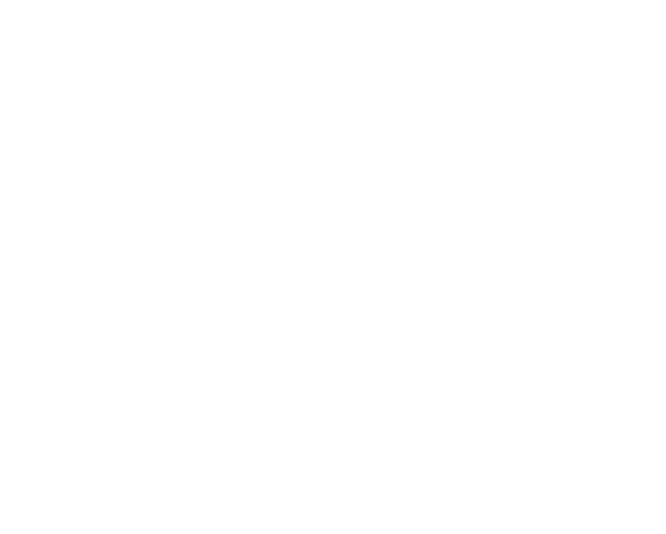

<IPython.core.display.Javascript object>


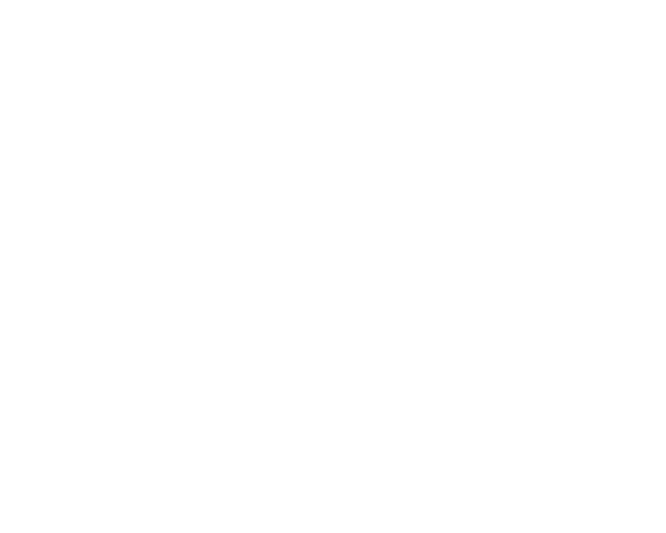

<IPython.core.display.Javascript object>


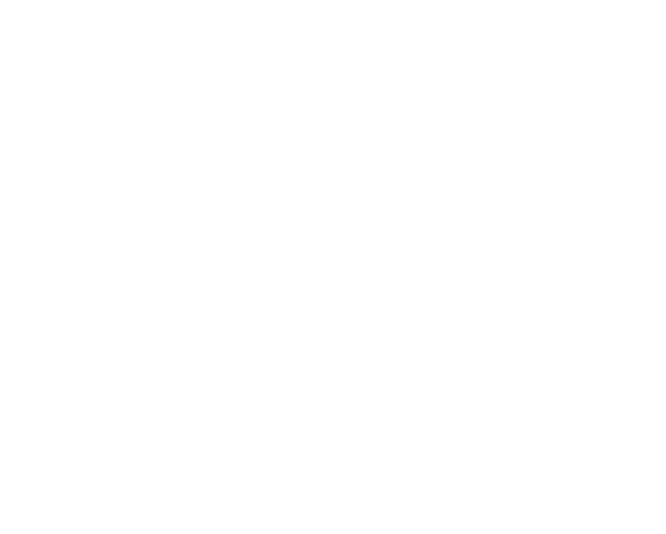

<IPython.core.display.Javascript object>


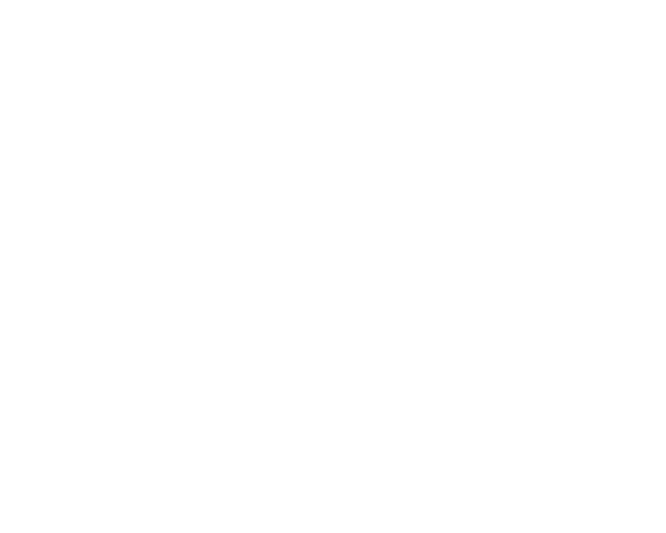

<IPython.core.display.Javascript object>


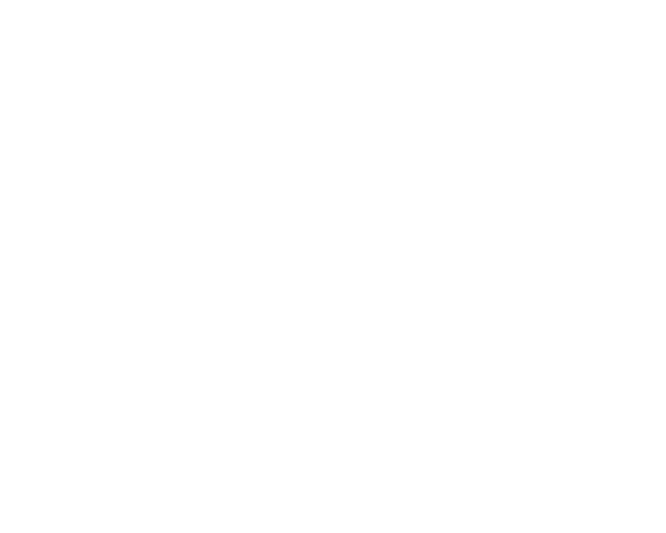

<IPython.core.display.Javascript object>


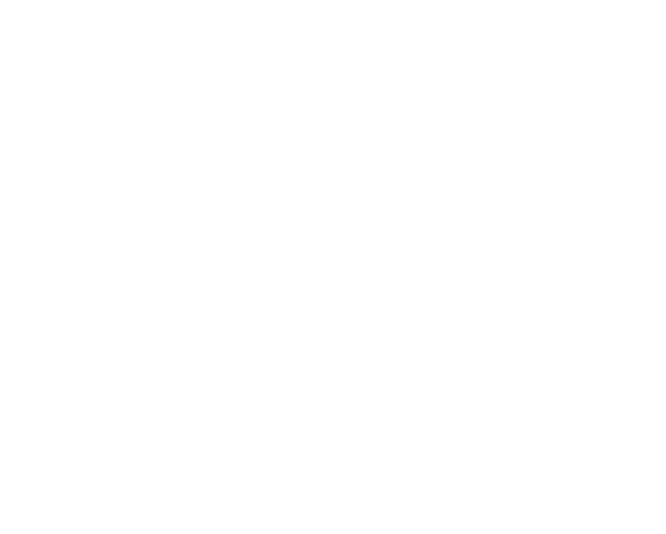

<IPython.core.display.Javascript object>


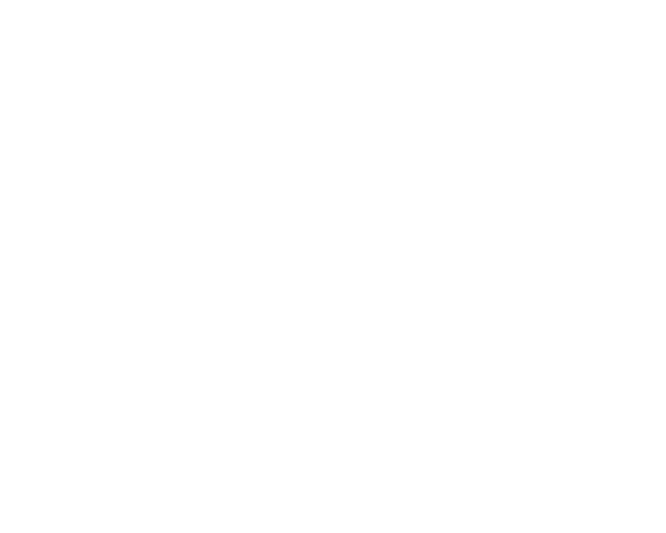

<IPython.core.display.Javascript object>


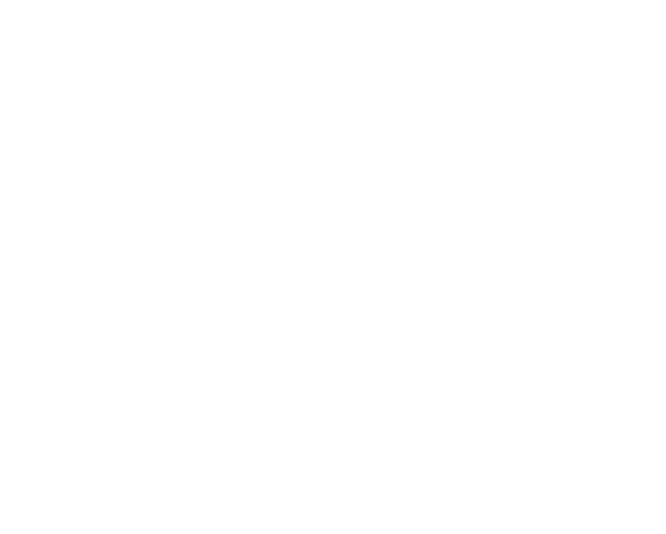

<IPython.core.display.Javascript object>


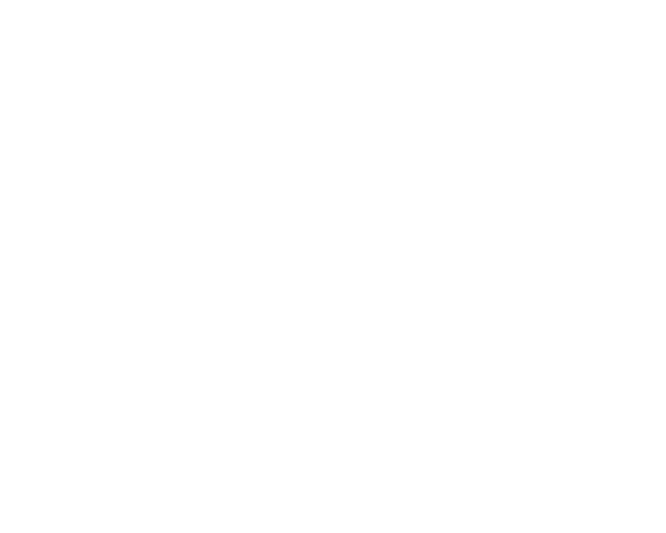

<IPython.core.display.Javascript object>


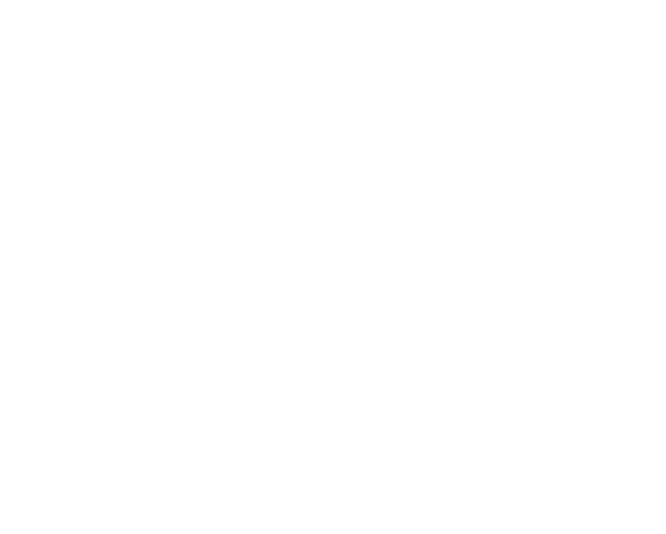

<IPython.core.display.Javascript object>


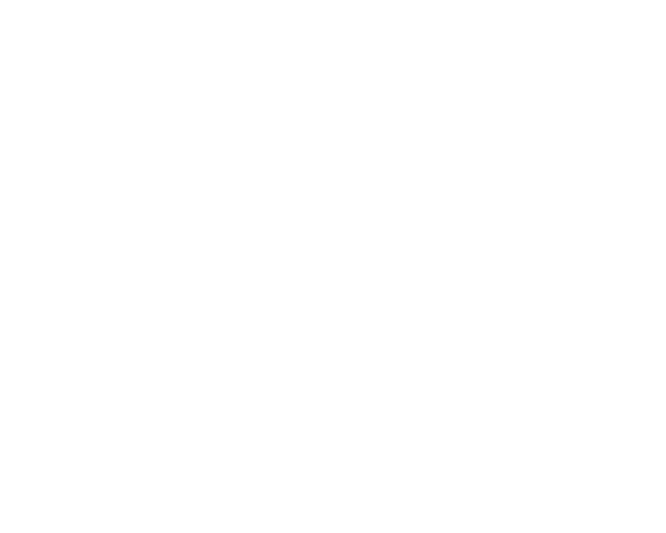

<IPython.core.display.Javascript object>


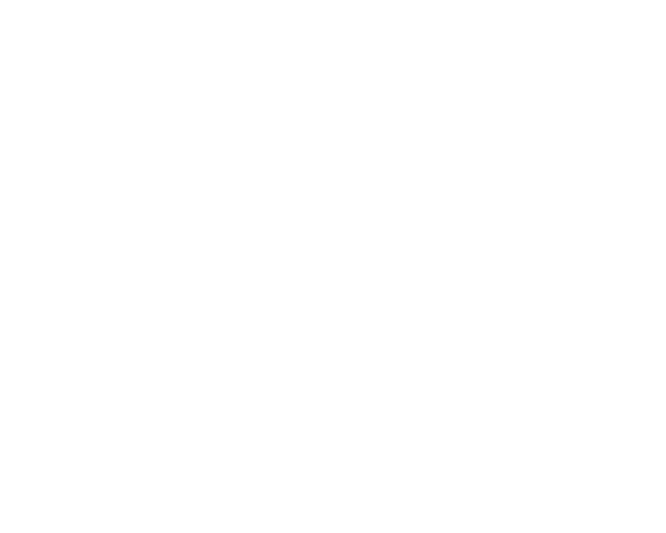

<IPython.core.display.Javascript object>


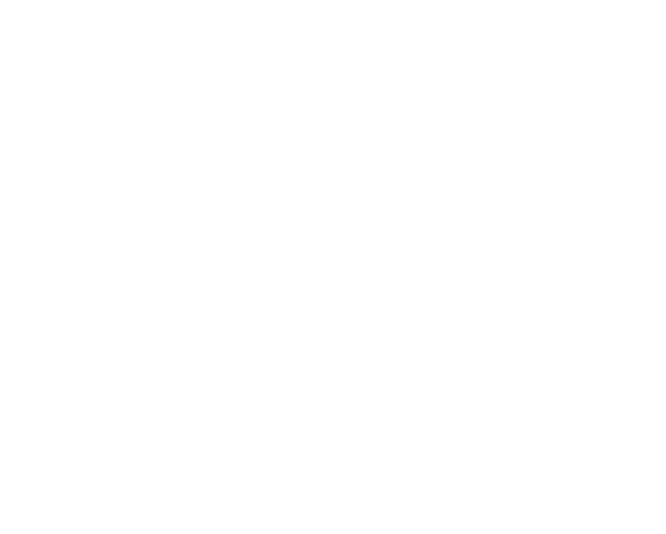

<IPython.core.display.Javascript object>


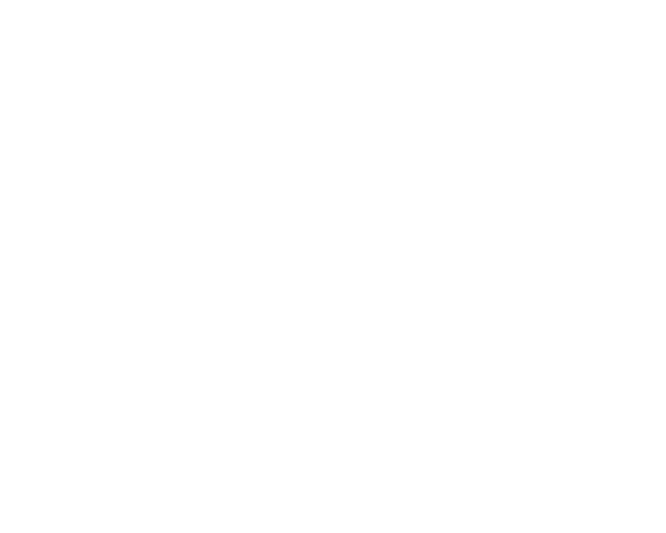

<IPython.core.display.Javascript object>


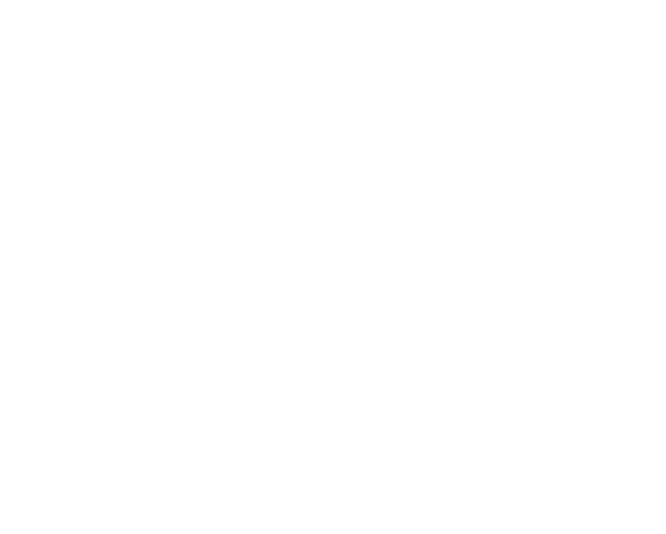

<IPython.core.display.Javascript object>


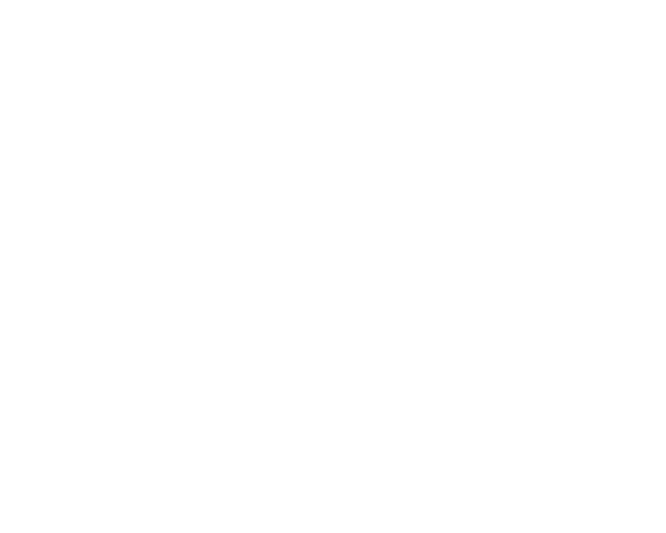

<IPython.core.display.Javascript object>


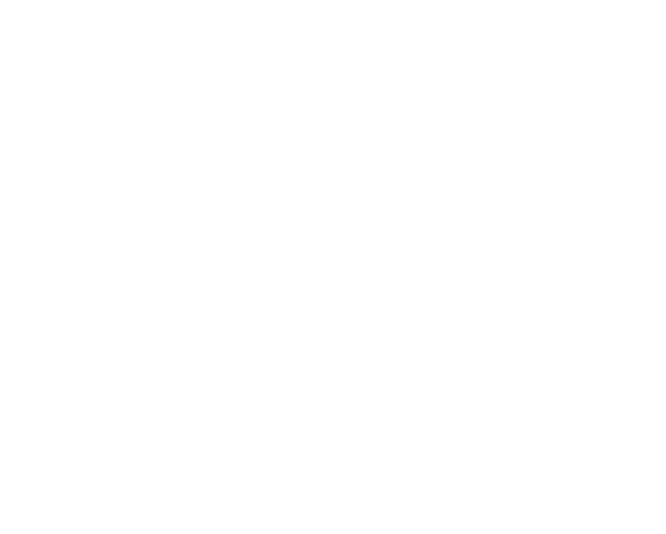

<IPython.core.display.Javascript object>


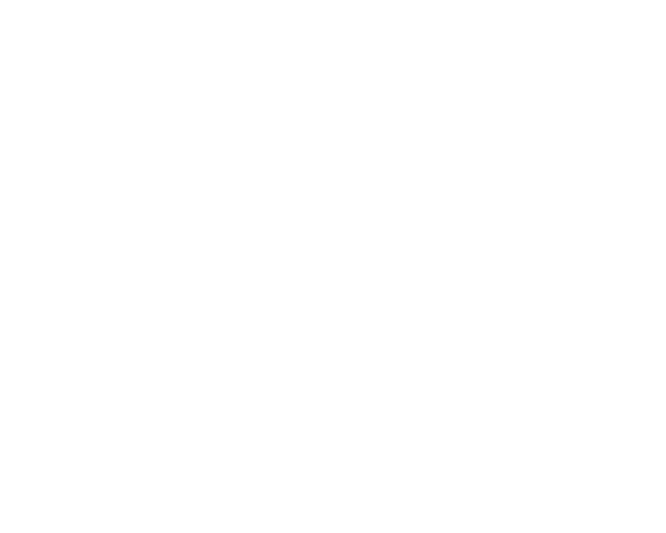

<IPython.core.display.Javascript object>


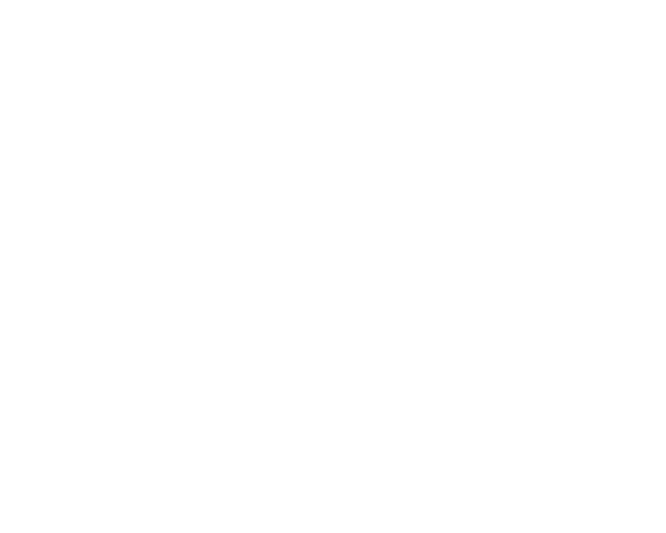

<IPython.core.display.Javascript object>


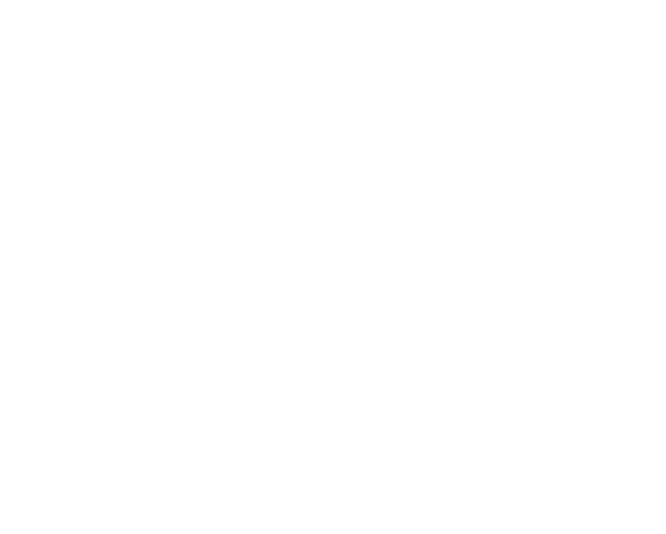

<IPython.core.display.Javascript object>


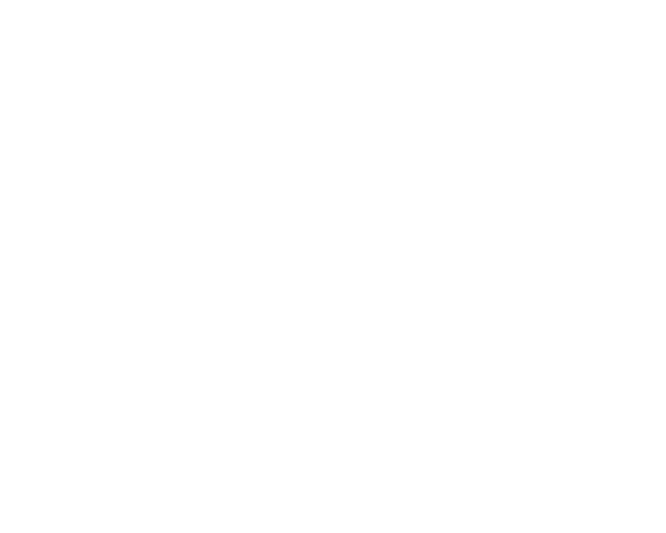

<IPython.core.display.Javascript object>


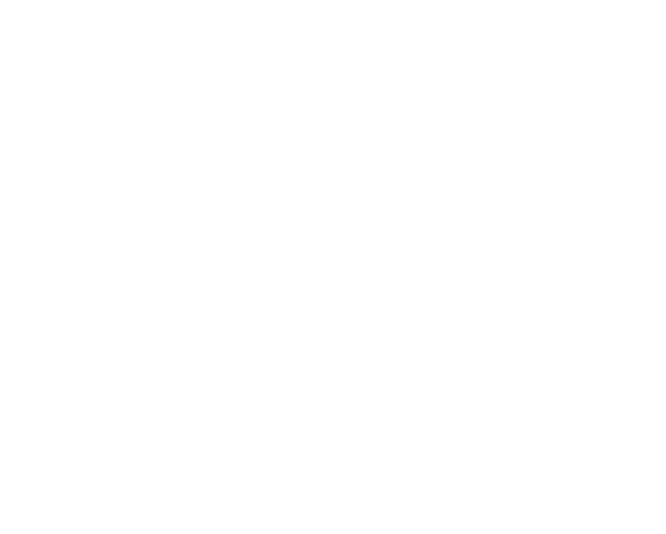

<IPython.core.display.Javascript object>


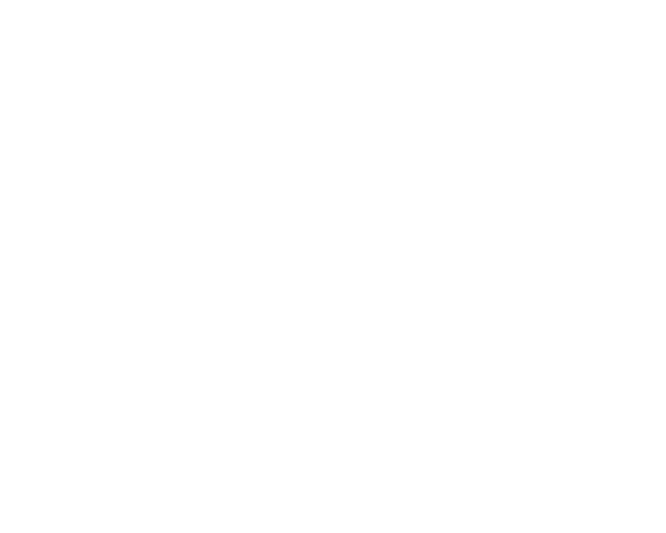

In [23]:
num = 0 
for num in range(25):
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    ax[0][0].imshow(ang1s[num][25:50, 600:700], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')
    ax[0][1].imshow(ang2s[num][25:50, 600:700], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')
    ax[1][0].plot(ang1s[num][50, 500:700], alpha=0.6, label="OAH1")
    ax[1][0].plot(ang2s[num][50, 500:700], alpha=0.6, label="OAH2")

    ax[1][1].plot(ang1s[num].T[50][50:250], alpha=0.6, label="OAH1")
    ax[1][1].plot(ang2s[num].T[50][50:250], alpha=0.6, label="OAH2")
    ax[1][1].set_ylim([-2, 2])

    ax[1][0].legend()
    ax[1][1].legend()

    plt.suptitle(f"2025-02-14 -- 197 -- {num}")
    for a in fig.axes:
        a.set_yticks([])
        a.set_xticks([])

    ax
    plt.tight_layout()

    plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/DifferentFlat/True/{str(num).zfill(5)}.png")

    plt.close()

In [54]:
images = [im[50:250, 600] for im in ang1s]
len(images)

25

<IPython.core.display.Javascript object>


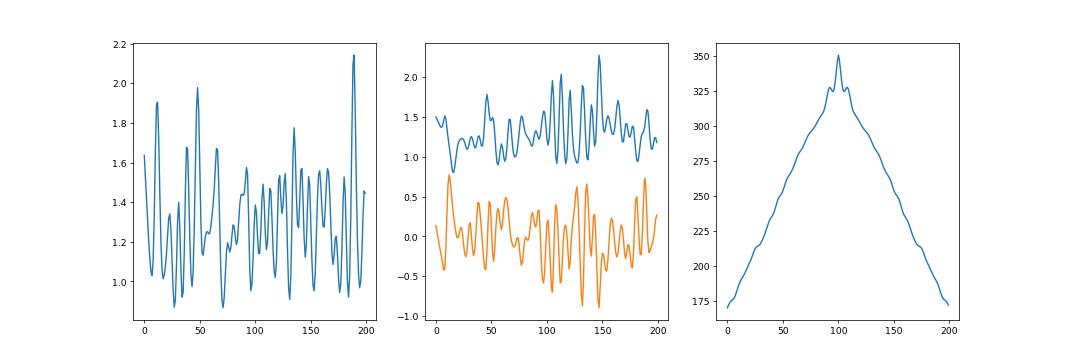

350.4180906165738


In [57]:
from scipy.signal import correlate

fig, ax = plt.subplots(1, 3)
ax[0].plot(images[23])
ax[1].plot(images[24])
ax[1].plot(images[23]-images[24])

corr = correlate(images[23], images[23], mode='same')  

ax[2].plot(corr)
print(corr.max())
plt.show()

In [26]:
from scipy.signal import correlate

In [28]:
cor_sameflat = correlate(ang1s_sameflat, ang2s_sameflat)

In [21]:
corr = correlate2d(images[0], images[1], mode='valid')  


<IPython.core.display.Javascript object>


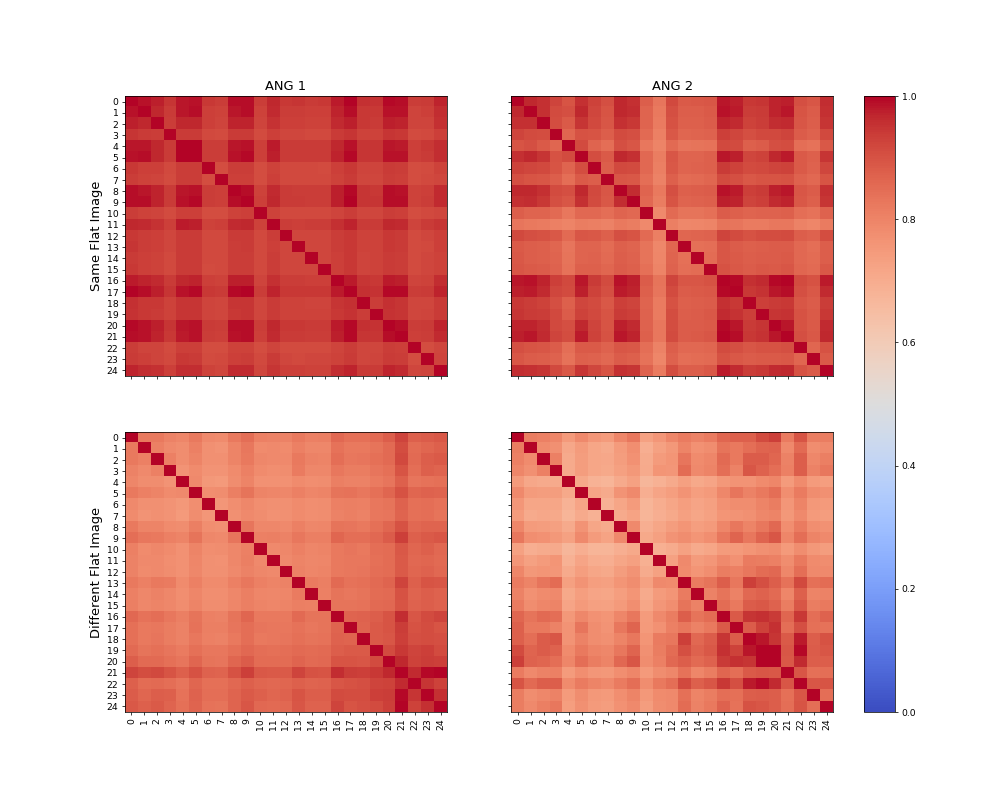

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Define datasets
datasets = {
    "ang1s_sameflat": ang1s_sameflat,
    "ang2s_sameflat": ang2s_sameflat,
    "ang1s": ang1s,
    "ang2s": ang2s
}

num_images = 25
lbls = range(num_images)

# Create figure for 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Loop through each dataset and compute correlation matrix
for idx, (name, image_set) in enumerate(datasets.items()):
    images = [im[50, 10:-10] for im in image_set]  # Extract column 600 from each image
    correlation_matrix = np.zeros((num_images, num_images))

    # Compute raw correlation values
    for i in range(num_images):
        for j in range(num_images):
            if i == j:
                correlation_matrix[i, j] = 1  # Self-correlation is always 1
            else:
                corr = correlate(images[i], images[j], mode='same')
                correlation_matrix[i, j] = np.max(corr)

    # Find the global max excluding the diagonal
    non_diag_max = np.max(correlation_matrix[np.triu_indices(num_images, k=1)])  # Excludes diagonal

    # Normalize the matrix by the global max
    if non_diag_max > 0:
        correlation_matrix /= non_diag_max  # Scale everything based on the highest non-diagonal value

    # Ensure diagonal remains exactly 1
    for i in range(num_images):
        correlation_matrix[i, i] = 1

    # Plot the correlation matrix in the grid
    ax = axes[idx // 2, idx % 2]
    im = ax.imshow(correlation_matrix, cmap="coolwarm", aspect="auto", vmin=0, vmax=1)
    ax.set_xticks(np.arange(num_images))
    ax.set_yticks(np.arange(num_images))
    ax.set_xticklabels(lbls, rotation=90)
    ax.set_yticklabels(lbls)

    
axes[0][0].set_title("ANG 1", fontsize=14)
axes[0][1].set_title("ANG 2", fontsize=14)
    
axes[0][0].set_ylabel("Same Flat Image", fontsize=14)
axes[1][0].set_ylabel("Different Flat Image", fontsize=14)

# Add colorbar

fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)

# plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


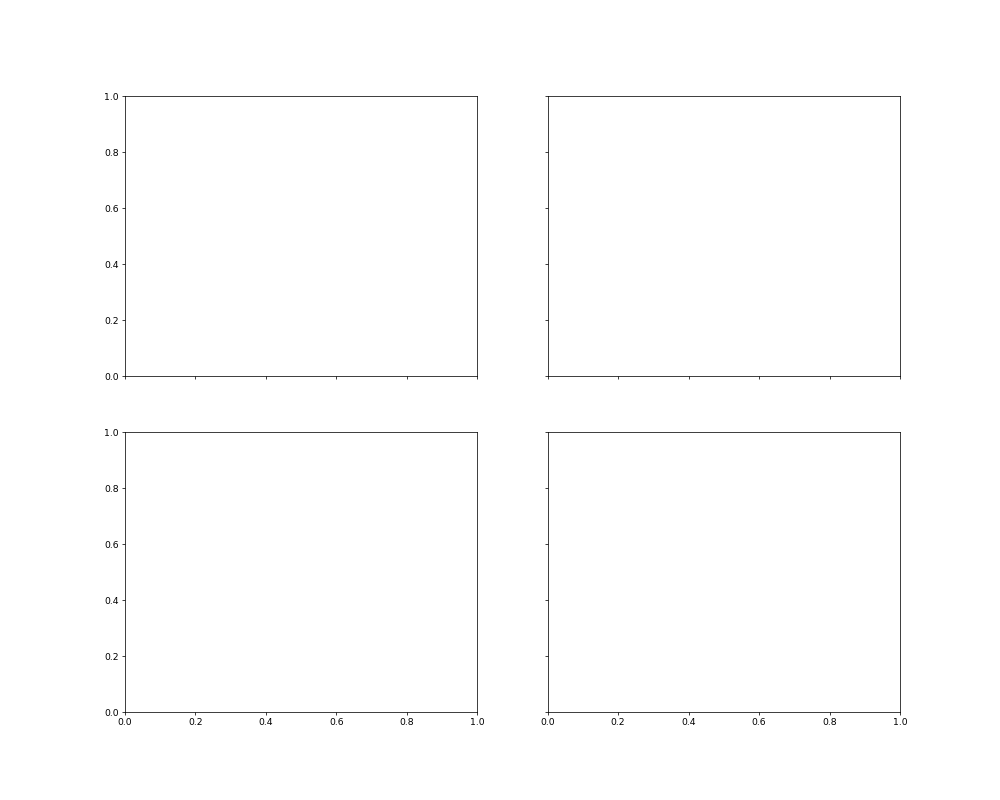

KeyboardInterrupt: 

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

# Define datasets
datasets = {
    "ang1s_sameflat": ang1s_sameflat,
    "ang2s_sameflat": ang2s_sameflat,
    "ang1s": ang1s,
    "ang2s": ang2s
}

num_images = 25
lbls = range(num_images)

# Create figure for 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Define the region of interest
region = (slice(50, 250), slice(400, 600))  # Equivalent to [50:250, 400:600]

# Loop through each dataset and compute correlation matrix
for idx, (name, image_set) in enumerate(datasets.items()):
    images = [im[region] for im in image_set]  # Extract the 2D region
    correlation_matrix = np.zeros((num_images, num_images))

    # Compute raw correlation values using 2D cross-correlation
    for i in range(num_images):
        for j in range(num_images):
            if i == j:
                correlation_matrix[i, j] = 1  # Self-correlation is always 1
            else:
                corr = correlate2d(images[i], images[j], mode='same', boundary='symm')
                correlation_matrix[i, j] = np.max(corr)  # Use the highest correlation value

    # Find the global max excluding the diagonal
    non_diag_max = np.max(correlation_matrix[np.triu_indices(num_images, k=1)])  # Excludes diagonal

    # Normalize the matrix by the global max
    if non_diag_max > 0:
        correlation_matrix /= non_diag_max  # Scale everything based on the highest non-diagonal value

    # Ensure diagonal remains exactly 1
    np.fill_diagonal(correlation_matrix, 1)

    # Plot the correlation matrix in the grid
    ax = axes[idx // 2, idx % 2]
    im = ax.imshow(correlation_matrix, cmap="coolwarm", aspect="auto", vmin=0, vmax=1)
    ax.set_xticks(np.arange(num_images))
    ax.set_yticks(np.arange(num_images))
    ax.set_xticklabels(lbls, rotation=90)
    ax.set_yticklabels(lbls)

# Set titles and labels
axes[0][0].set_title("ANG 1", fontsize=14)
axes[0][1].set_title("ANG 2", fontsize=14)
axes[0][0].set_ylabel("Same Flat Image", fontsize=14)
axes[1][0].set_ylabel("Different Flat Image", fontsize=14)

# Add colorbar
fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)

plt.show()
